1. 환경 설정 및 라이브러리 설치
2. 사전 학습된 SSD 모델 로드
3. 테스트 이미지 준비
4. Object Detection 실행
5. 결과 시각화
6. 웹캠/동영상 실시간 탐지 (보너스)

In [1]:
# 1-1. 필수 라이브러리 import
import torch
import torchvision
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 한글 폰트 설정 (matplotlib 한글 깨짐 방지)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("="*50)
print("SSD Object Detection 실습 시작!")
print("="*50)
print(f"PyTorch 버전: {torch.__version__}")
print(f"TorchVision 버전: {torchvision.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 디바이스 설정 (GPU 있으면 GPU, 없으면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")
print("="*50)

SSD Object Detection 실습 시작!
PyTorch 버전: 2.9.0+cu126
TorchVision 버전: 0.24.0+cu126
CUDA 사용 가능: True
사용 디바이스: cuda


In [2]:
"""
사전 학습된 SSD300 모델 로드
- COCO 데이터셋으로 학습됨 (80개 클래스)
- 입력 크기: 300x300
"""
# 최신 가중치 사용 (2025년 1월 기준)
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights)

# 모델을 평가 모드로 설정 (중요!)
model.eval()
model = model.to(device)


print(f"모델 타입: {type(model).__name__}")

# COCO 데이터셋 클래스 이름 가져오기
class_names = weights.meta["categories"]
print(f"\n탐지 가능한 클래스 수: {len(class_names)}개")
print(f"클래스 예시: {class_names[:10]}")

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:00<00:00, 198MB/s]


모델 타입: SSD

탐지 가능한 클래스 수: 91개
클래스 예시: ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']


이미지 다운로드: https://images.unsplash.com/photo-1449965408869-eaa3f722e40d?w=800
이미지 로드 완료! 크기: (800, 533)
전처리 완료! 텐서 크기: torch.Size([1, 3, 533, 800])


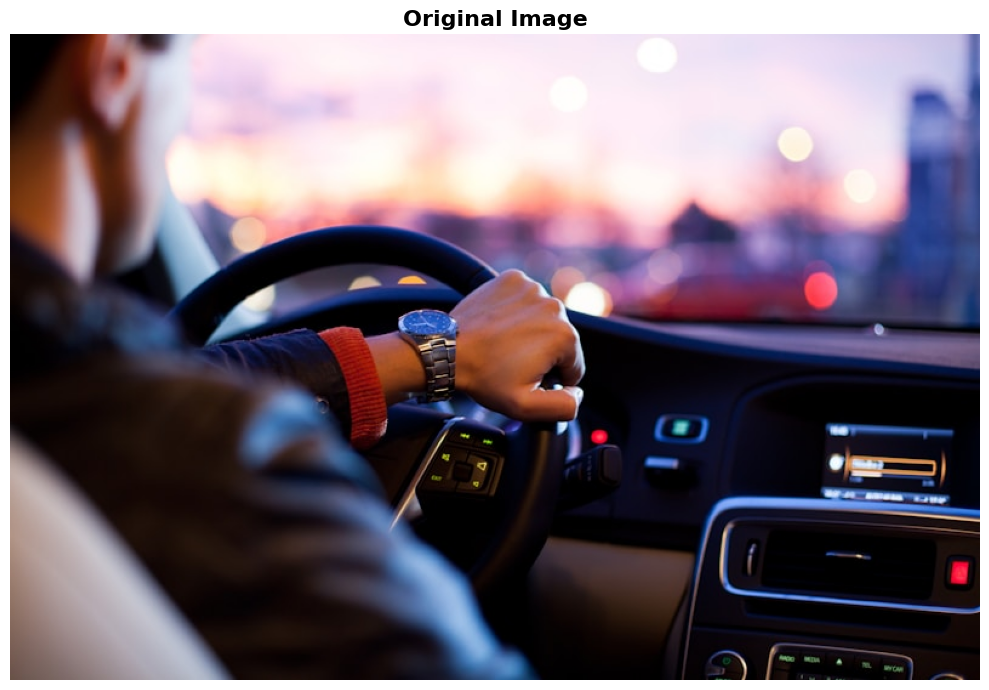

In [3]:
"""
테스트 이미지 다운로드 및 전처리
"""

def download_image(url):
    """
    URL에서 이미지 다운로드

    Args:
        url: 이미지 URL
    Returns:
        PIL Image
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        return img
    except Exception as e:
        print(f"이미지 다운로드 실패: {e}")
        return None

def preprocess_image(image):
    """
    이미지 전처리

    Args:
        image: PIL Image
    Returns:
        tensor: [1, 3, H, W] 형태의 텐서
        original: 원본 이미지 (시각화용)
    """
    # PIL Image를 텐서로 변환 [3, H, W]
    img_tensor = F.to_tensor(image)

    # 배치 차원 추가 [1, 3, H, W]
    img_tensor = img_tensor.unsqueeze(0)

    # 원본 이미지 저장 (시각화용)
    original = image.copy()

    return img_tensor, original

# 테스트 이미지 URL (사람, 자동차, 강아지가 있는 거리 사진)
test_image_urls = [
    "https://images.unsplash.com/photo-1568605114967-8130f3a36994?w=800",  # 사람들
    "https://images.unsplash.com/photo-1449965408869-eaa3f722e40d?w=800",  # 거리 풍경
    "https://images.unsplash.com/photo-1544568100-847a948585b9?w=800",   # 강아지
]

# 두 번째 이미지 다운로드
image_url = test_image_urls[1]
print(f"이미지 다운로드: {image_url}")

image = download_image(image_url)

if image is not None:
    print(f"이미지 로드 완료! 크기: {image.size}")

    # 이미지 전처리
    img_tensor, original_image = preprocess_image(image)
    print(f"전처리 완료! 텐서 크기: {img_tensor.shape}")

    # 원본 이미지 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(original_image)
    plt.title("Original Image", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("이미지를 불러올 수 없습니다.")


In [4]:
"""
SSD로 객체 탐지 수행
"""

def detect_objects(model, image_tensor, confidence_threshold=0.5):
    """
    객체 탐지 수행

    Args:
        model: SSD 모델
        image_tensor: [1, 3, H, W] 입력 이미지
        confidence_threshold: 신뢰도 임계값 (기본 0.5)

    Returns:
        predictions: 탐지 결과 딕셔너리
    """
    print(f"\n객체 탐지 시작... (신뢰도 임계값: {confidence_threshold})")

    # 디바이스로 이동
    image_tensor = image_tensor.to(device)

    # 추론 (Inference)
    with torch.no_grad():  # Gradient 계산 비활성화 (추론 시 필수!)
        predictions = model(image_tensor)

    # 결과는 리스트 형태 (배치 크기만큼)
    # predictions[0]: 첫 번째 이미지의 결과
    pred = predictions[0]

    # 신뢰도가 임계값 이상인 것만 필터링
    keep_indices = pred['scores'] > confidence_threshold # (default) 0.5

    filtered_pred = {
        'boxes': pred['boxes'][keep_indices],      # [N, 4] (x1, y1, x2, y2)
        'labels': pred['labels'][keep_indices],    # [N] 클래스 ID
        'scores': pred['scores'][keep_indices]     # [N] 신뢰도 점수
    }

    num_detections = len(filtered_pred['boxes'])
    print(f"탐지 완료! 발견된 객체 수: {num_detections}개")

    # 탐지된 객체별 정보 출력
    if num_detections > 0:
        print("\n탐지된 객체 목록:")
        print("-" * 60)
        for i in range(num_detections):
            label_id = filtered_pred['labels'][i].item()
            score = filtered_pred['scores'][i].item()
            class_name = class_names[label_id]
            print(f"{i+1}. {class_name:15s} | 신뢰도: {score:.2%}")
        print("-" * 60)

    return filtered_pred


# 객체 탐지 실행
predictions = detect_objects(model, img_tensor, confidence_threshold=0.5)


객체 탐지 시작... (신뢰도 임계값: 0.5)
탐지 완료! 발견된 객체 수: 1개

탐지된 객체 목록:
------------------------------------------------------------
1. person          | 신뢰도: 83.64%
------------------------------------------------------------


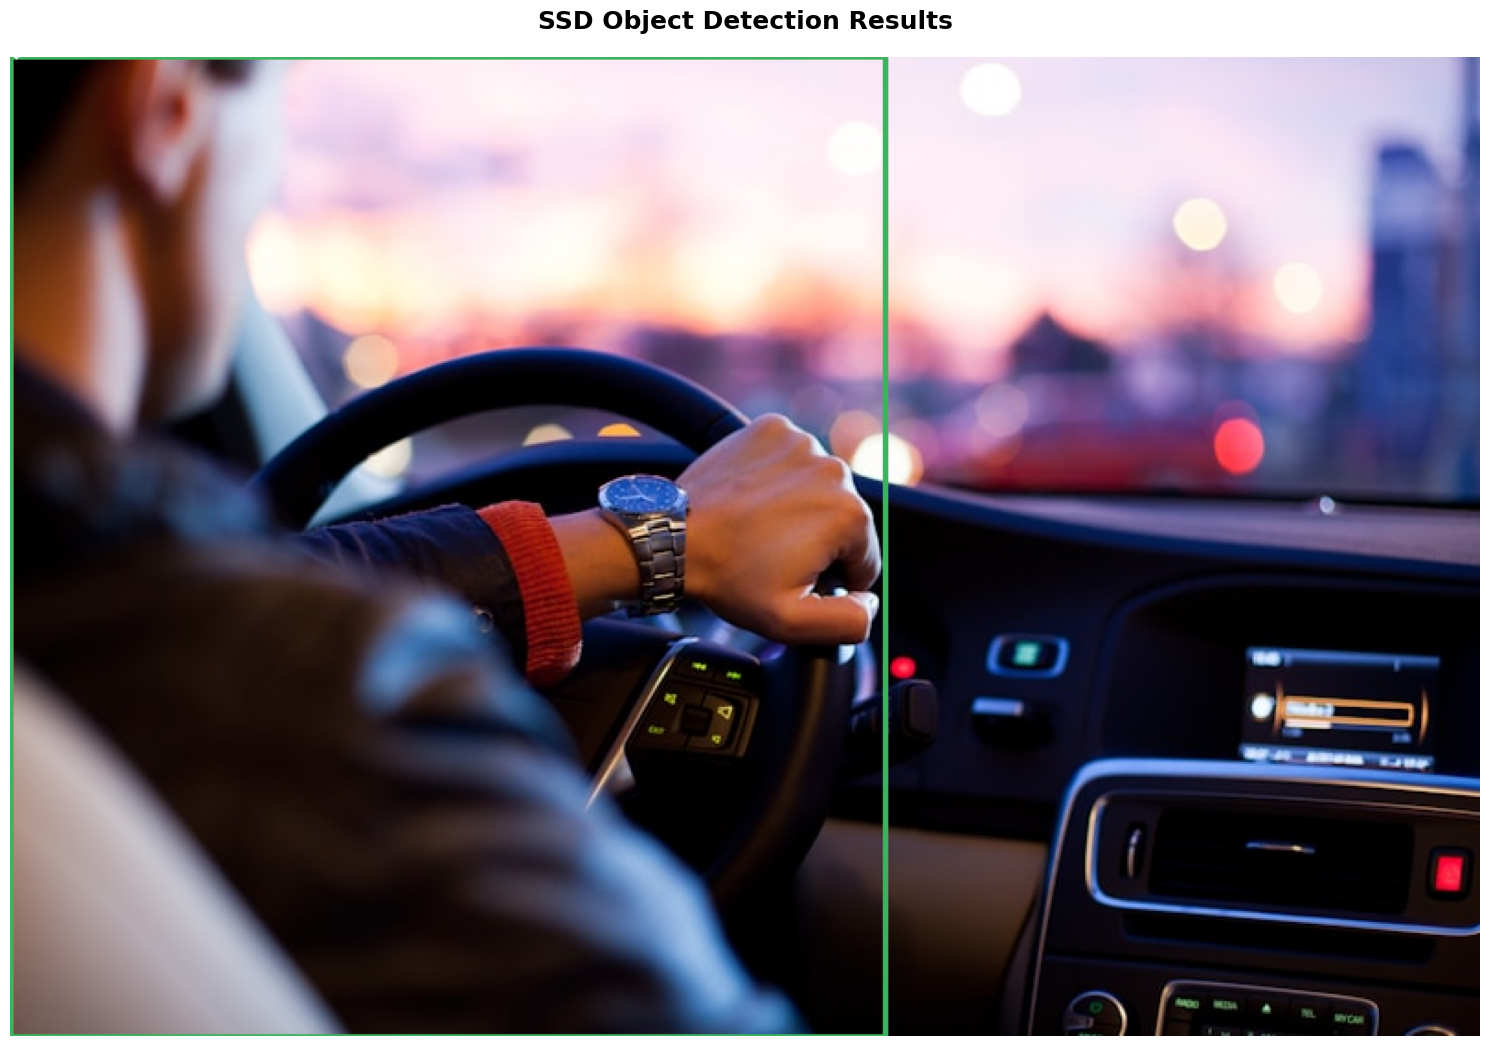

In [5]:
"""
탐지 결과를 이미지에 그리기
"""

def visualize_predictions(image, predictions, class_names,
                         font_scale=0.8, thickness=3):
    """
    탐지 결과 시각화

    Args:
        image: PIL Image (원본)
        predictions: 탐지 결과
        class_names: 클래스 이름 리스트
        font_scale: 텍스트 크기
        thickness: 박스 두께

    Returns:
        numpy array: 시각화된 이미지
    """
    # PIL Image를 numpy array로 변환
    img_np = np.array(image)
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    boxes = predictions['boxes'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()

    # 색상 팔레트 (클래스별 다른 색상)
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)

    # 각 탐지 결과 그리기
    for box, label, score in zip(boxes, labels, scores):
        # 박스 좌표 (x1, y1, x2, y2)
        x1, y1, x2, y2 = box.astype(int)

        # 클래스 이름과 색상
        class_name = class_names[label]
        color = colors[label].tolist()

        # 박스 그리기
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, thickness)

        # 레이블 텍스트
        text = f"{class_name}: {score:.2f}"

        # 텍스트 배경 (가독성 향상)
        (text_width, text_height), _ = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
        )

        cv2.rectangle(
            img_cv,
            (x1, y1 - text_height - 10),
            (x1 + text_width, y1),
            color,
            -1  # 채우기
        )

        # 텍스트 그리기
        cv2.putText(
            img_cv,
            text,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),  # 흰색 텍스트
            thickness
        )

    # BGR을 RGB로 변환
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    return img_rgb

# 시각화
result_image = visualize_predictions(
    original_image,
    predictions,
    class_names,
    font_scale=0.7,
    thickness=2
)

# 결과 출력
plt.figure(figsize=(15, 12))
plt.imshow(result_image)
plt.title("SSD Object Detection Results", fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
"""
다양한 이미지로 테스트
"""

def test_multiple_images(model, image_urls, class_names, confidence_threshold=0.5):
    """
    여러 이미지로 객체 탐지 테스트

    Args:
        model: SSD 모델
        image_urls: 이미지 URL 리스트
        class_names: 클래스 이름 리스트
        confidence_threshold: 신뢰도 임계값
    """
    num_images = len(image_urls)

    # 서브플롯 생성
    fig, axes = plt.subplots(num_images, 2, figsize=(20, 8*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)

    for idx, url in enumerate(image_urls):
        print(f"\n{'='*60}")
        print(f"테스트 {idx+1}/{num_images}: {url}")
        print('='*60)

        # 이미지 다운로드
        image = download_image(url)
        if image is None:
            continue

        # 전처리
        img_tensor, original = preprocess_image(image)

        # 객체 탐지
        predictions = detect_objects(model, img_tensor, confidence_threshold)

        # 시각화
        result = visualize_predictions(original, predictions, class_names)

        # 원본과 결과 비교
        axes[idx, 0].imshow(original)
        axes[idx, 0].set_title(f"Original Image {idx+1}", fontsize=14, fontweight='bold')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(result)
        axes[idx, 1].set_title(f"Detection Result {idx+1} ({len(predictions['boxes'])} objects)",
                               fontsize=14, fontweight='bold')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()


print("\n" + "="*60)

# 다양한 테스트 이미지
test_urls = [
    "https://images.unsplash.com/photo-1568605114967-8130f3a36994?w=800",  # 사람들
    "https://images.unsplash.com/photo-1449965408869-eaa3f722e40d?w=800",  # 거리
    "https://images.unsplash.com/photo-1544568100-847a948585b9?w=800",   # 강아지
]

# 테스트 실행
test_multiple_images(model, test_urls, class_names, confidence_threshold=0.5)

Output hidden; open in https://colab.research.google.com to view.


신뢰도 임계값 비교


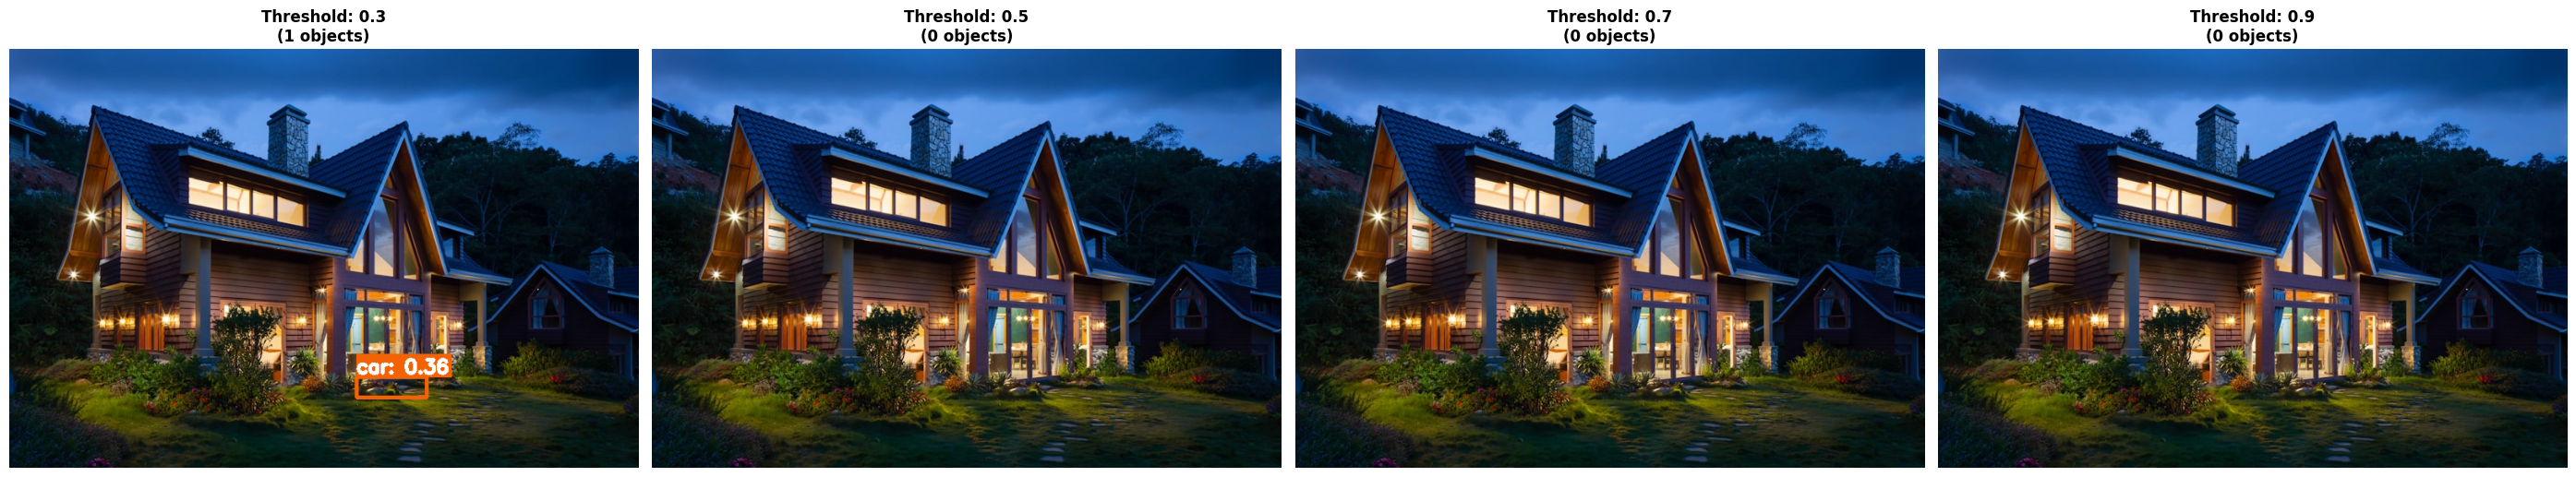


임계값별 탐지 객체 수:
----------------------------------------
Threshold 0.3:   1개
Threshold 0.5:   0개
Threshold 0.7:   0개
Threshold 0.9:   0개
----------------------------------------


In [7]:
"""
신뢰도 임계값에 따른 결과 비교
"""

def compare_thresholds(model, image, class_names, thresholds=[0.3, 0.5, 0.7, 0.9]):
    """
    다양한 신뢰도 임계값 비교

    Args:
        model: SSD 모델
        image: PIL Image
        class_names: 클래스 이름 리스트
        thresholds: 테스트할 임계값 리스트
    """
    # 전처리
    img_tensor, original = preprocess_image(image)

    # 한 번만 추론
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        predictions_full = model(img_tensor)[0]

    # 서브플롯 생성
    num_thresholds = len(thresholds)
    fig, axes = plt.subplots(1, num_thresholds, figsize=(7*num_thresholds, 7))

    if num_thresholds == 1:
        axes = [axes]

    for idx, threshold in enumerate(thresholds):
        # 임계값으로 필터링
        keep = predictions_full['scores'] > threshold
        filtered = {
            'boxes': predictions_full['boxes'][keep],
            'labels': predictions_full['labels'][keep],
            'scores': predictions_full['scores'][keep]
        }

        num_detections = len(filtered['boxes'])

        # 시각화
        result = visualize_predictions(original, filtered, class_names)

        axes[idx].imshow(result)
        axes[idx].set_title(
            f"Threshold: {threshold}\n({num_detections} objects)",
            fontsize=12,
            fontweight='bold'
        )
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # 통계 출력
    print("\n임계값별 탐지 객체 수:")
    print("-" * 40)
    for threshold in thresholds:
        keep = predictions_full['scores'] > threshold
        count = keep.sum().item()
        print(f"Threshold {threshold:.1f}: {count:3d}개")
    print("-" * 40)


print("\n" + "="*60)
print("신뢰도 임계값 비교")
print("="*60)

# 테스트 이미지 준비
test_url = "https://images.unsplash.com/photo-1568605114967-8130f3a36994?w=800"
image = download_image(test_url)

if image is not None:
    compare_thresholds(
        model,
        image,
        class_names,
        thresholds=[0.3, 0.5, 0.7, 0.9]
    )



아래 셀을 실행하면 파일 업로드 창이 나타납니다.
이미지를 선택하여 업로드하세요!

이미지를 업로드하세요...


Saving different-types-of-poodle-dog-breed-information-pictures-characteristics.png to different-types-of-poodle-dog-breed-information-pictures-characteristics.png
업로드된 파일: different-types-of-poodle-dog-breed-information-pictures-characteristics.png
이미지 크기: (1200, 675)

객체 탐지 시작... (신뢰도 임계값: 0.2)
탐지 완료! 발견된 객체 수: 11개

탐지된 객체 목록:
------------------------------------------------------------
1. sheep           | 신뢰도: 86.09%
2. dog             | 신뢰도: 48.28%
3. sheep           | 신뢰도: 45.03%
4. sheep           | 신뢰도: 42.24%
5. sheep           | 신뢰도: 29.68%
6. dog             | 신뢰도: 25.35%
7. sheep           | 신뢰도: 25.14%
8. sheep           | 신뢰도: 24.62%
9. dog             | 신뢰도: 23.31%
10. teddy bear      | 신뢰도: 23.18%
11. dog             | 신뢰도: 21.81%
------------------------------------------------------------


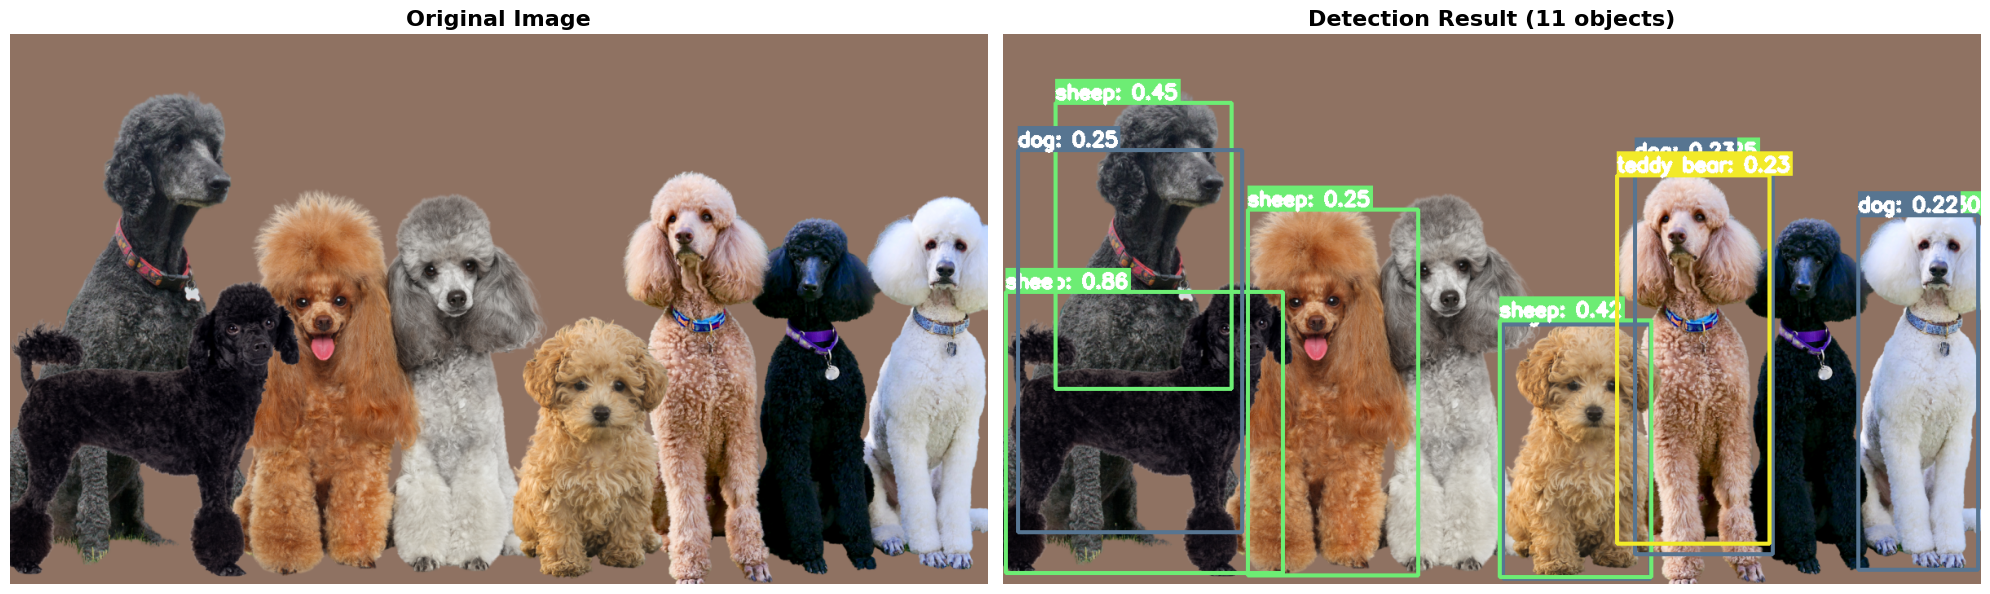

In [11]:
"""
직접 업로드한 이미지로 테스트
"""

# Colab에서 파일 업로드 기능 사용
from google.colab import files

def test_uploaded_image(model, class_names, confidence_threshold=0.5):
    """
    사용자가 업로드한 이미지로 테스트
    """
    print("이미지를 업로드하세요...")
    uploaded = files.upload()

    if len(uploaded) == 0:
        print("업로드된 파일이 없습니다.")
        return

    # 업로드된 첫 번째 이미지 사용
    filename = list(uploaded.keys())[0]
    print(f"업로드된 파일: {filename}")

    # 이미지 로드
    image = Image.open(filename).convert('RGB')
    print(f"이미지 크기: {image.size}")

    # 전처리
    img_tensor, original = preprocess_image(image)

    # 탐지
    predictions = detect_objects(model, img_tensor, confidence_threshold)

    # 시각화
    result = visualize_predictions(original, predictions, class_names)

    # 결과 출력
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].imshow(original)
    axes[0].set_title("Original Image", fontsize=16, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(result)
    axes[1].set_title(f"Detection Result ({len(predictions['boxes'])} objects)",
                     fontsize=16, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


print("\n" + "="*60)
print("="*60)
print("\n아래 셀을 실행하면 파일 업로드 창이 나타납니다.")
print("이미지를 선택하여 업로드하세요!\n")

# 실행
test_uploaded_image(model, class_names, confidence_threshold=0.2)